In [206]:
import pandas as pd
import numpy as np


df = pd.read_csv("chennai_final_dataset.csv")

df['date'] = pd.to_datetime(df['date'], dayfirst=True)


df = df.drop_duplicates()

df['event'] = df['event'].fillna('None')
df['type'] = df['type'].fillna('None')
df['traffic_impact'] = df['traffic_impact'].fillna('Low')



daily_df = df.groupby(['date', 'Junction'], observed=False).agg({
    'Vehicles': 'sum',
    'temperature': 'mean',
    'rain (mm)': 'sum',
    'precipitation (mm)': 'sum',
    'snow_depth (m)': 'sum',
    'event': 'first',
    'type': 'first',
    'traffic_impact': 'first'
}).reset_index()


daily_df['day_of_week'] = daily_df['date'].dt.dayofweek
daily_df['month'] = daily_df['date'].dt.month
daily_df['week_of_year'] = daily_df['date'].dt.isocalendar().week
daily_df['is_weekend'] = (daily_df['day_of_week'] >= 5).astype(int)


daily_df['is_event_day'] = (daily_df['event'] != 'None').astype(int)


daily_df = daily_df.sort_values(['Junction', 'date'])

daily_df['vehicles_lag_1'] = daily_df.groupby('Junction', observed=False)['Vehicles'].shift(1)
daily_df['vehicles_lag_7'] = daily_df.groupby('Junction', observed=False)['Vehicles'].shift(7)


daily_df['vehicles_roll_3'] = (
    daily_df.groupby('Junction', observed=False)['Vehicles']
            .rolling(3).mean().reset_index(0, drop=True)
)

daily_df['vehicles_roll_7'] = (
    daily_df.groupby('Junction', observed=False)['Vehicles']
            .rolling(7).mean().reset_index(0, drop=True)
)


encoded_df = pd.get_dummies(
    daily_df,
    columns=['event', 'type', 'traffic_impact'],
    drop_first=True
)


preprocessed_df = encoded_df.copy()

preprocessed_df.head()


,date,Junction,Vehicles,temperature,rain (mm),precipitation (mm),snow_depth (m),day_of_week,month,week_of_year,...,event_Tamil New Year Eve Shopping,type_Festival,type_Festival Activity,type_Major Festival,type_None,type_Public Holiday,type_Religious Event,type_Return Travel,traffic_impact_Low,traffic_impact_Medium
0,2015-11-01,1,327,25.987500,0.862500,0.862500,0,6,11,44,...,False,False,False,False,True,False,False,False,True,False
3,2015-11-02,1,546,25.941667,0.187500,0.187500,0,0,11,45,...,False,False,False,False,True,False,False,False,True,False
6,2015-11-03,1,544,26.862500,0.291667,0.291667,0,1,11,45,...,False,False,False,False,True,False,False,False,True,False
9,2015-11-04,1,498,26.712500,0.362500,0.362500,0,2,11,45,...,False,False,False,False,True,False,False,False,True,False
12,2015-11-05,1,464,26.787500,0.037500,0.037500,0,3,11,45,...,False,False,False,False,True,False,False,False,True,False


In [207]:
df['traffic_zscore'] = (df['Vehicles'] - df['Vehicles'].mean()) / df['Vehicles'].std()
df['rolling_7'] = df.groupby('Junction')['Vehicles'].rolling(7).mean().reset_index(0, drop=True)
df['rolling_3'] = df.groupby('Junction')['Vehicles'].rolling(3).mean().reset_index(0, drop=True)


In [208]:
threshold = df['Vehicles'].quantile(0.90)
df['is_peak_day'] = (df['Vehicles'] >= threshold).astype(int)


In [209]:
df['day_of_week'] = df['date'].dt.day_name()
weekday_pattern = df.groupby(['day_of_week', 'Junction'])['Vehicles'].mean()


In [210]:
df['month'] = df['date'].dt.month
monthly_pattern = df.groupby(['month', 'Junction'])['Vehicles'].mean()


In [211]:
df[['Vehicles', 'temperature', 'rain (mm)']].corr()


,Vehicles,temperature,rain (mm)
Vehicles,1.000000,0.103698,-0.046398
temperature,0.103698,1.000000,-0.155345
rain (mm),-0.046398,-0.155345,1.000000


In [212]:
event_impact = df.groupby('event')['Vehicles'].mean().sort_values(ascending=False)


✅ Random Forest Results:
 {'Train MAE': 14.538678051865908, 'Val MAE': 60.65121212121211, 'Train RMSE': 23.910248241449565, 'Val RMSE': 104.72885526323428, 'Train R2': 0.996358725572922, 'Val R2': 0.9690861322833872}

✅ Best Gradient Boosting Results:
 {'Train MAE': 20.06184899643069, 'Val MAE': 20.443141346021466, 'Train RMSE': 27.343589008882997, 'Val RMSE': 27.435738649084332, 'Train R2': 0.9952379245032271, 'Val R2': 0.9978784467077559}

✅ Best GB Model: GradientBoostingRegressor(learning_rate=0.05, max_depth=5, n_estimators=200,
                          random_state=42, subsample=0.8)

✅ Time-Based Cross-Validation Results:
    Fold        MAE        RMSE        R2
0     1  46.951217   66.678343  0.932612
1     2  78.721284  128.573190  0.876860
2     3  65.553652   97.418865  0.956069
3     4  56.510547   91.097144  0.970854
4     5  72.113903  124.395593  0.957989

✅ Average CV Performance:
 Fold      3.000000
MAE      63.970121
RMSE    101.632627
R2        0.938877
dtype: floa

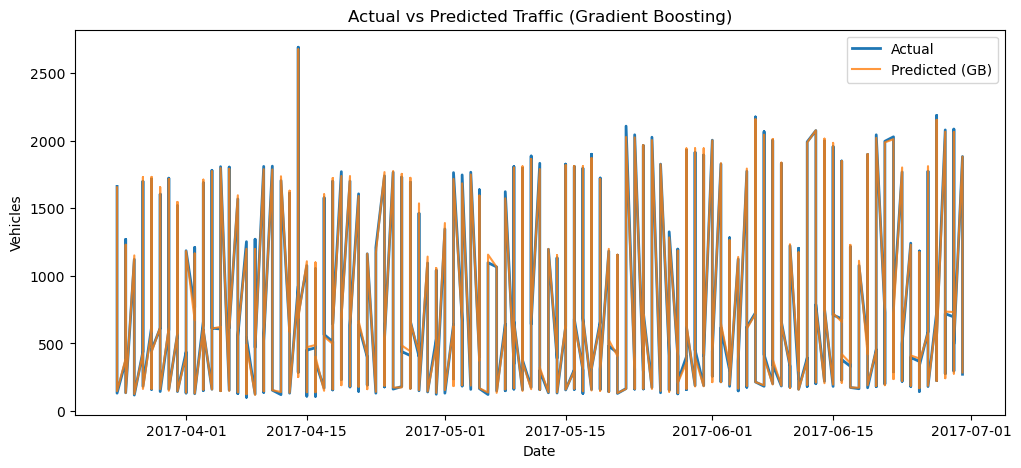

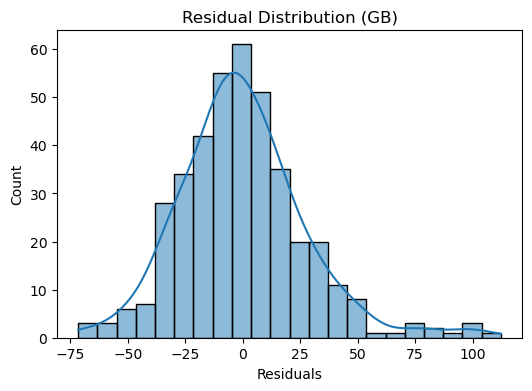

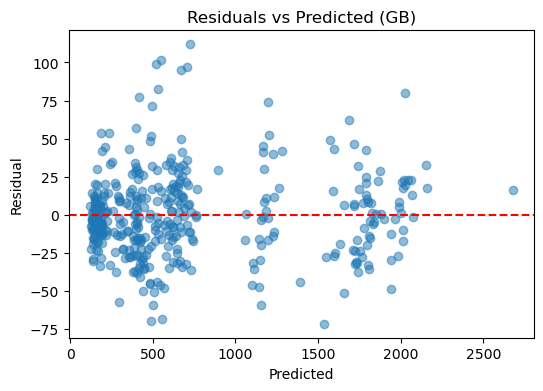

In [248]:
# ============================================================
# ✅ COMPLETE MODEL DEVELOPMENT, TUNING, EVALUATION & CV PIPELINE
# ============================================================

import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# ------------------------------------------------------------
# 1. SORT DATA & PREPARE FEATURES
# ------------------------------------------------------------
data = preprocessed_df.sort_values('date')

X = data.drop(['Vehicles', 'date'], axis=1)
y = data['Vehicles']

# ------------------------------------------------------------
# 2. CLEAN NaN VALUES BEFORE ANY MODELING
# ------------------------------------------------------------
X_clean = X.dropna()
y_clean = y.loc[X_clean.index]

# ------------------------------------------------------------
# 3. TIME-BASED TRAIN/VALIDATION SPLIT
# ------------------------------------------------------------
split_idx = int(len(X_clean) * 0.8)

X_train = X_clean.iloc[:split_idx]
y_train = y_clean.iloc[:split_idx]

X_val = X_clean.iloc[split_idx:]
y_val = y_clean.iloc[split_idx:]

# ------------------------------------------------------------
# 4. BASELINE MODEL — RANDOM FOREST
# ------------------------------------------------------------
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)

# ------------------------------------------------------------
# 5. GRADIENT BOOSTING + GRID SEARCH (HYPERPARAMETER TUNING)
# ------------------------------------------------------------
gb = GradientBoostingRegressor(random_state=42)

param_grid_gb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5],
    'subsample': [0.8, 1.0]
}

tscv = TimeSeriesSplit(n_splits=5)

gb_grid = GridSearchCV(
    gb,
    param_grid=param_grid_gb,
    scoring='neg_mean_absolute_error',
    cv=tscv,
    n_jobs=-1
)

gb_grid.fit(X_clean, y_clean)
best_gb = gb_grid.best_estimator_

# ------------------------------------------------------------
# 6. EVALUATION FUNCTION
# ------------------------------------------------------------
def evaluate(model, X_train, y_train, X_val, y_val):
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)

    results = {
        'Train MAE': mean_absolute_error(y_train, y_train_pred),
        'Val MAE': mean_absolute_error(y_val, y_val_pred),
        'Train RMSE': np.sqrt(mean_squared_error(y_train, y_train_pred)),
        'Val RMSE': np.sqrt(mean_squared_error(y_val, y_val_pred)),
        'Train R2': r2_score(y_train, y_train_pred),
        'Val R2': r2_score(y_val, y_val_pred)
    }
    return results, y_val_pred

# ------------------------------------------------------------
# 7. EVALUATE BOTH MODELS
# ------------------------------------------------------------
rf_results, rf_pred = evaluate(rf, X_train, y_train, X_val, y_val)
gb_results, gb_pred = evaluate(best_gb, X_train, y_train, X_val, y_val)

print("✅ Random Forest Results:\n", rf_results)
print("\n✅ Best Gradient Boosting Results:\n", gb_results)
print("\n✅ Best GB Model:", best_gb)

# ------------------------------------------------------------
# 8. TIME-BASED CROSS VALIDATION (MODEL ROBUSTNESS)
# ------------------------------------------------------------
cv_scores = []
for fold, (train_idx, val_idx) in enumerate(tscv.split(X_clean)):
    X_tr, X_vl = X_clean.iloc[train_idx], X_clean.iloc[val_idx]
    y_tr, y_vl = y_clean.iloc[train_idx], y_clean.iloc[val_idx]

    model = GradientBoostingRegressor(random_state=42)
    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_vl)

    cv_scores.append({
        'Fold': fold + 1,
        'MAE': mean_absolute_error(y_vl, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_vl, y_pred)),
        'R2': r2_score(y_vl, y_pred)
    })

cv_df = pd.DataFrame(cv_scores)
print("\n✅ Time-Based Cross-Validation Results:\n", cv_df)
print("\n✅ Average CV Performance:\n", cv_df.mean())

# ------------------------------------------------------------
# 9. FIX DATE ALIGNMENT FOR PLOTTING
# ------------------------------------------------------------
val_dates = data['date'].loc[X_val.index]

# ------------------------------------------------------------
# 10. VISUALIZATIONS — ACTUAL VS PREDICTED
# ------------------------------------------------------------
plt.figure(figsize=(12,5))
plt.plot(val_dates, y_val.values, label='Actual', linewidth=2)
plt.plot(val_dates, gb_pred, label='Predicted (GB)', alpha=0.8)
plt.title("Actual vs Predicted Traffic (Gradient Boosting)")
plt.xlabel("Date")
plt.ylabel("Vehicles")
plt.legend()
plt.show()

# ------------------------------------------------------------
# 11. RESIDUAL PLOTS
# ------------------------------------------------------------
residuals = y_val - gb_pred

plt.figure(figsize=(6,4))
sns.histplot(residuals, kde=True)
plt.title("Residual Distribution (GB)")
plt.xlabel("Residuals")
plt.show()

plt.figure(figsize=(6,4))
plt.scatter(gb_pred, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs Predicted (GB)")
plt.xlabel("Predicted")
plt.ylabel("Residual")
plt.show()
